In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import os
import math
import torch

from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_curve, accuracy_score
from functools import partial, reduce

In [75]:
import warnings
warnings.filterwarnings("ignore")

## Analysis of CLAM C-Kit 11 classification results
* **accuracy**, **confusion-matrix**, **ROC-curves** and **AUC**
* histogram of **model posteriors**
* determine **operating point** on val. set
* determine **confidence** of validation metrics

#### additionally
* correlations in predictions (special features in misclassified samples)
* analyze heatmaps of misclassified samples

In [76]:
exp_list = ['c-kit-mutation', 
            'c-kit-mutation-moco', 
            'c-kit-mutation-moco-imgnet', 
            'c-kit-mutation-moco-imgnet-lrlower']

In [77]:
def summary(exp_path):
    summary_csv = pd.read_csv('../results/{}_s1/summary.csv'.format(exp_path))
    # mean val metrics
    print(exp_path)
    print('\n')
    print("Mean val accuracy \033[1m {} \033[0m".format(summary_csv['val_acc'].mean()))
    print("Mean val AUC {}".format(summary_csv['val_auc'].mean()))
    print("Mean test accuracy \033[1m {} \033[0m".format(summary_csv['test_acc'].mean()))
    print("Mean test AUC {}".format(summary_csv['test_auc'].mean()))
    print('\n')

In [78]:
for exp_path in exp_list:
    summary(exp_path)

c-kit-mutation


Mean val accuracy  0.7942857142857143 
Mean val AUC 0.8617386480908152
Mean test accuracy  0.6657894736842105 
Mean test AUC 0.7392045454545454


c-kit-mutation-moco


Mean val accuracy  0.76 
Mean val AUC 0.8407274681802546
Mean test accuracy  0.6631578947368422 
Mean test AUC 0.7420454545454546


c-kit-mutation-moco-imgnet


Mean val accuracy  0.78 
Mean val AUC 0.8605271757825937
Mean test accuracy  0.7236842105263157 
Mean test AUC 0.7710227272727272


c-kit-mutation-moco-imgnet-lrlower


Mean val accuracy  0.7914285714285715 
Mean val AUC 0.8791417268661851
Mean test accuracy  0.6947368421052632 
Mean test AUC 0.7451704545454545




### Prediction accuracy of positive and negative samples

In [91]:
def print_confusion_matrix(exp_path):
    # load evaluation results val. set
    folds = {}
    for fold in range(10):
        folds[fold] = pd.read_csv(f'../eval_results/EVAL_{exp_path}/fold_{fold}.csv')

    data_full = pd.concat(folds.values(), axis=0)
    
    y = np.array([])
    y_hat = np.array([])

    for fold in folds:
        y = np.append(y, folds[fold]['Y'])
        y_hat = np.append(y_hat, folds[fold]['Y_hat'])
        
    # confusion matrix
    cm = confusion_matrix(y, y_hat)
    # Normalise
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(8,6))
    sns.heatmap(cmn, annot=True, fmt='.2f', cmap="YlGnBu")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(exp_path)
    plt.show(block=False)

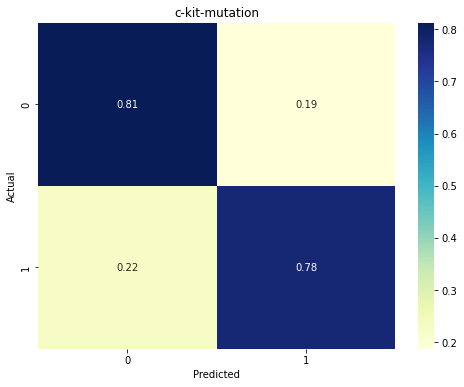

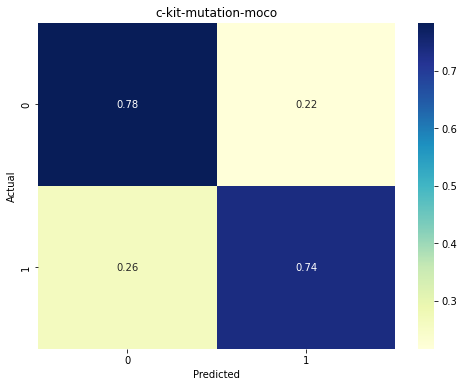

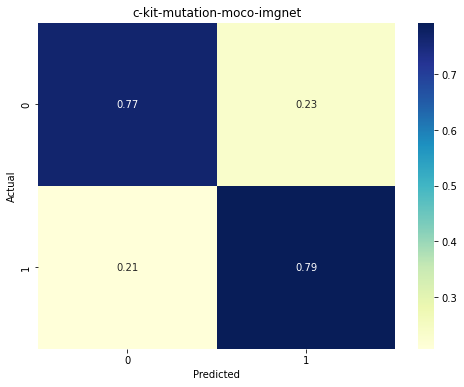

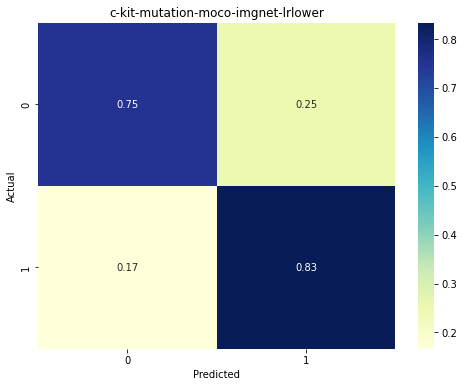

In [92]:
for exp_path in exp_list:
    print_confusion_matrix(exp_path)

In [93]:
def print_acc_per_class(exp_path):
    # load evaluation results val. set
    folds = {}
    for fold in range(10):
        folds[fold] = pd.read_csv(f'../eval_results/EVAL_{exp_path}/fold_{fold}.csv')

    data_full = pd.concat(folds.values(), axis=0)
    
    # show accuracy per class for each fold
    pos_acc = np.array([])
    neg_acc = np.array([])
    for fold in folds:
        f = folds[fold]
        _, recall, _, _ = precision_recall_fscore_support(f['Y'], f['Y_hat'])
        pos_acc = np.append(pos_acc, recall[1])
        neg_acc = np.append(neg_acc, recall[0])
    acc_per_class = pd.DataFrame(data={'pos': pos_acc, 'neg': neg_acc})
    
    sns.boxplot(data=acc_per_class)
    plt.ylim(0.3, 1)
    plt.ylabel('Accuracy')
    plt.title(f'{exp_path} Accuracy per class (over 10 folds)')
    plt.show()

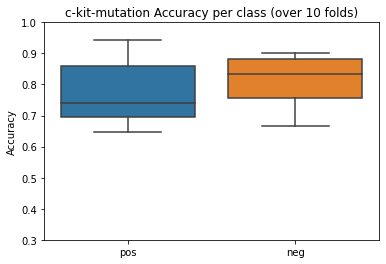

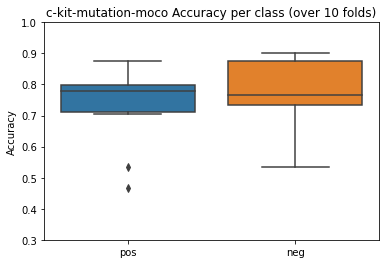

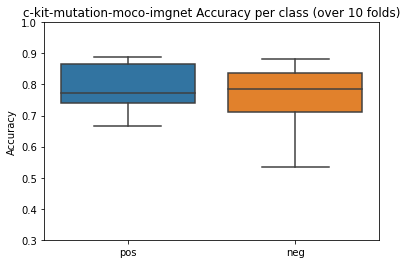

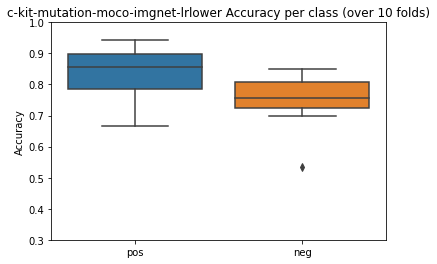

In [94]:
for exp_path in exp_list:
    print_acc_per_class(exp_path)

In [95]:
def print_distribution(exp_path):
    # load evaluation results val. set
    folds = {}
    for fold in range(10):
        folds[fold] = pd.read_csv(f'../eval_results/EVAL_{exp_path}/fold_{fold}.csv')
    
    pos_df = pd.DataFrame([])
    neg_df = pd.DataFrame([])

    for fold in folds:
        f = folds[fold]
        f['fold'] = np.full(f.shape[0], fold)
        pos = f.loc[f['Y'] == 1]
        neg = f.loc[f['Y'] == 0]
        pos_df = pos_df.append(pos)
        neg_df = neg_df.append(neg)
        
    plt.figure(figsize=(15,7))
    plt.hist(neg_df['p_1'], bins=50, label='Negatives')
    plt.hist(pos_df['p_1'], bins=50, label='Positives', alpha=0.7, color='r')
    plt.xlabel('Probability of being Positive Class', fontsize=25)
    plt.ylabel('Number of samples', fontsize=25)
    plt.legend(fontsize=15)
    plt.title(exp_path, fontsize=25)
    plt.tick_params(axis='both', labelsize=25, pad=5)
    plt.show()

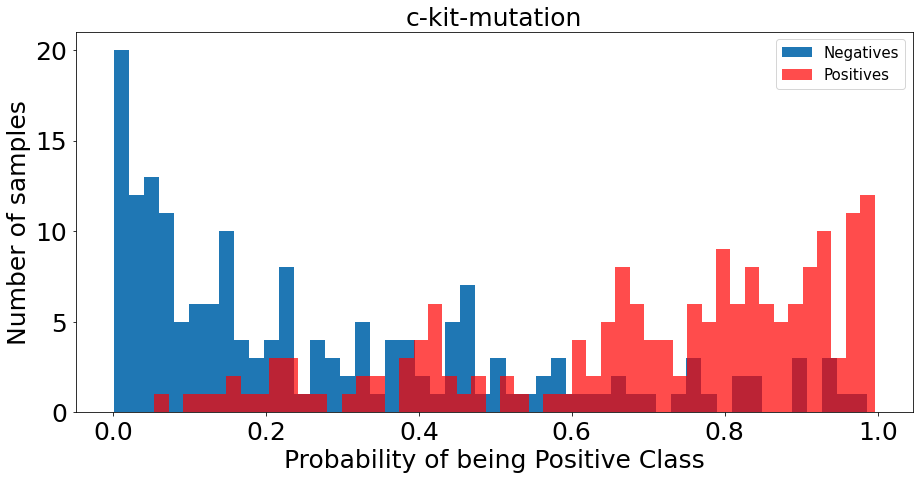

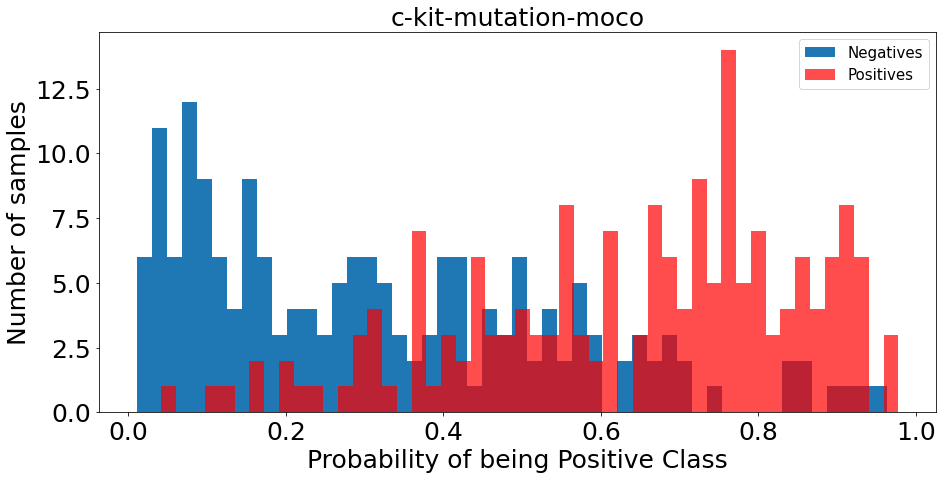

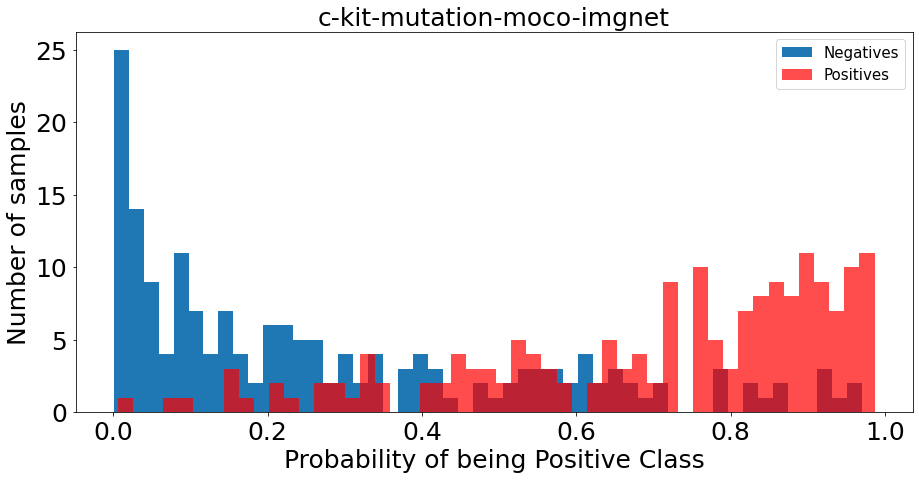

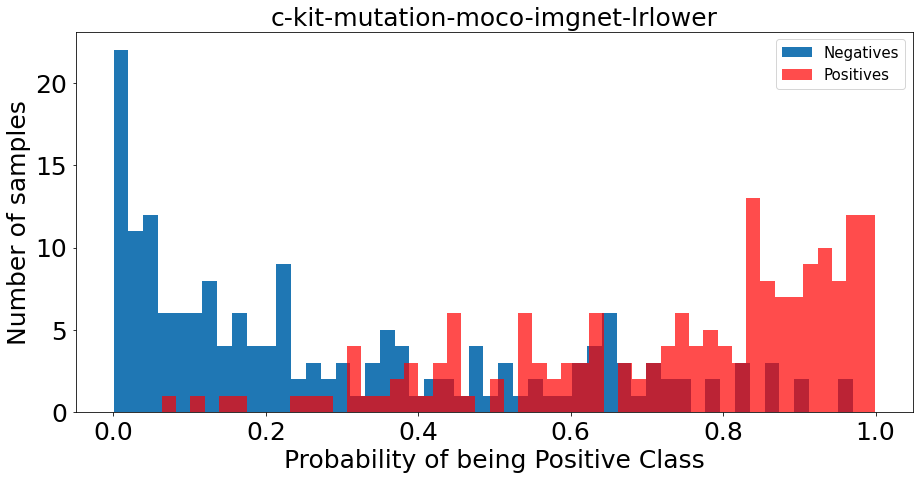

In [96]:
for exp_path in exp_list:
    print_distribution(exp_path)

In [97]:
def print_ROC(exp_path):
    # load evaluation results val. set
    folds = {}
    for fold in range(10):
        folds[fold] = pd.read_csv(f'../eval_results/EVAL_{exp_path}/fold_{fold}.csv')
        
    # ROC curve
    tprs = []
    base_fpr = np.linspace(0, 1, 101)

    plt.figure(figsize=(7, 7))
    plt.axes().set_aspect('equal', 'datalim')

    for fold in folds:
        f = folds[fold]
        fpr, tpr, _ = roc_curve(f['Y'], f['p_1'])

        plt.plot(fpr, tpr, 'b', alpha=0.1)
        tpr = np.interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tprs.append(tpr)

    tprs = np.array(tprs)
    mean_tprs = tprs.mean(axis=0)
    std = tprs.std(axis=0)

    tprs_upper = np.minimum(mean_tprs + std, 1)
    tprs_lower = mean_tprs - std


    plt.plot(base_fpr, mean_tprs, 'b')
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title(exp_path)
    plt.show()

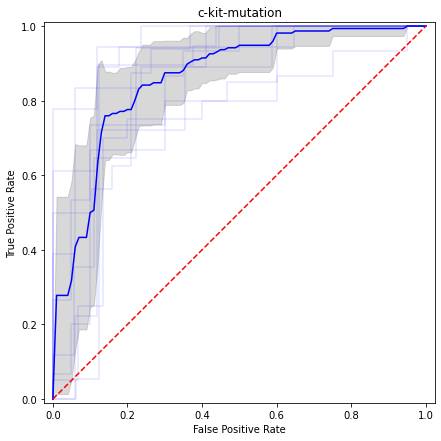

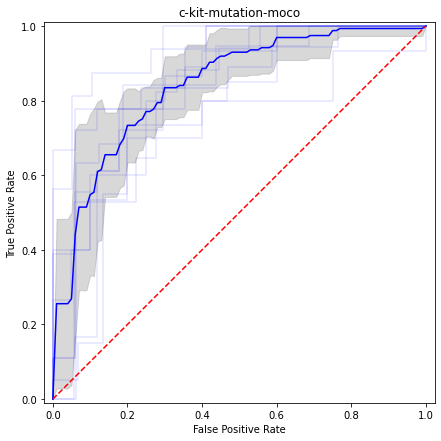

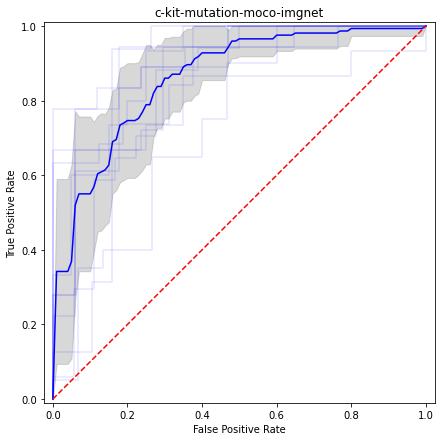

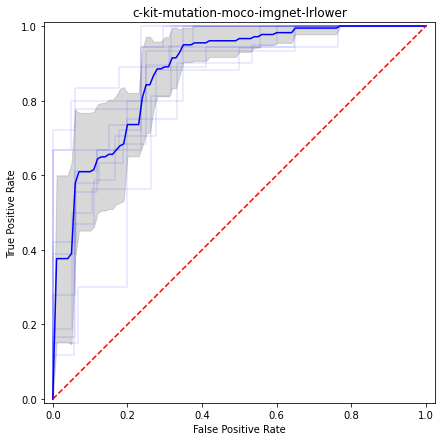

In [98]:
for exp_path in exp_list:
    print_ROC(exp_path)

## Optimal Threshold ROC curve

In [87]:
# calculate the g-mean for each threshold
optimal_thresh_arr = []
for fold in folds:
    f = folds[fold]
    fpr, tpr, thresh = roc_curve(f['Y'], f['p_1'])
    gmeans = np.sqrt(tpr * (1 - fpr))
    idx = np.argmax(gmeans)
    optimal_thresh_arr.append(thresh[idx])
    
optimal_thresh = np.mean(optimal_thresh_arr)

In [88]:
print(optimal_thresh)

0.6351709097623826


In [89]:
acc_arr = []
for fold in folds:
    probs = folds[fold]['p_1'].apply(lambda x: 1 if x > optimal_thresh else 0)
    acc_arr.append(accuracy_score(folds[fold]['Y'] ,probs))

In [90]:
np.mean(acc_arr)

0.6842105263157895

## Correlations with misclassified samples

- **Corellations between misclassified samples and other variables**
- **Corellations between misclassified samples and size of image**

In [21]:
ckit_metadata_raw = pd.read_excel('../dataset_csv/ckit_data_metadata.xlsx', 
                              sheet_name=['1.Ladung Kit-11-POSITIV', '2.Ladung Kit-11-POSITIV',
                                          '1.Ladung Kit-NEGATIV', '2.Ladung Kit-NEGATIV'])
import re
# join worksheets                                                            
ckit_metadata = pd.concat(ckit_metadata_raw.values(), axis=0)

# only keep rows with MP ID
ckit_metadata = ckit_metadata[ckit_metadata['MP ID'].notna()]

# only keep important columns
ckit_metadata = ckit_metadata[['MP ID', 'Breed', 'Age (years)', 'KIT Pattern', 'Ki67', 'AgNOR', 'AgNOR x Ki67', 'Kiupel', 'Patnaik']]
ckit_metadata['MP ID'] = 'CP_' + ckit_metadata['MP ID'].astype(str)

# add MP ID to slides in model prediction data; delete endings (_L1, _L2, _H1, _H2)
data_full['MP ID'] = data_full['slide_id'].transform(lambda x: re.sub('_[^_]*$', '', x) if x.count('_')>1 else x).astype(str)

In [22]:
ckit_metadata

,MP ID,Breed,Age (years),KIT Pattern,Ki67,AgNOR,AgNOR x Ki67,Kiupel,Patnaik
0,CP_MP-21-0009973,Mixed,12,2.0,31.4,2.7,84.78,High,2.0
1,CP_MP-21-0009594,Mixed,11,2.0,18.4,1.43,26.37,High,2.0
2,CP_MP-21-0009589,Boxer,6,2.0,13.4,2.57,34.39,High,3.0
3,CP_MP-21-0009587,?,?,2.0,17.8,3.2,56.96,High,2.0
4,CP_MP-21-0009586,Vizsla,11,2.0,36,3.7,133.2,Low,2.0
...,...,...,...,...,...,...,...,...,...
80,CP_MP-17-0014094,Pug,7,2.0,17,2,34,Low,2
81,CP_MP-17-0013531,Mixed,?,2.0,38,2.3,87.4,Low,2
82,CP_MP-21-0000853,Basset Hound,11,2.0,12,1.4,16.8,Low,1
83,CP_MP-21-0000225,"Poodle, Toy",7,2.0,1.6,1.47,2.35,Low,1


In [23]:
data_full

,slide_id,Y,Y_hat,p_0,p_1,MP ID
0,CP_MP-20-0002232,1.0,1.0,0.389528,0.610472,CP_MP-20-0002232
1,CP_MP-21-0005067,1.0,1.0,0.093505,0.906495,CP_MP-21-0005067
2,CP_MP-20-0015231,1.0,1.0,0.090393,0.909607,CP_MP-20-0015231
3,CP_MP-18-0000802,1.0,1.0,0.140991,0.859009,CP_MP-18-0000802
4,CP_MP-21-0001084,1.0,1.0,0.076545,0.923455,CP_MP-21-0001084
...,...,...,...,...,...,...
33,CP_MP-19-0004177_H2,0.0,0.0,0.771118,0.228882,CP_MP-19-0004177
34,CP_MP-21-0000828_H2,0.0,1.0,0.427902,0.572098,CP_MP-21-0000828
35,CP_MP-21-0009224_H2,0.0,0.0,0.575742,0.424259,CP_MP-21-0009224
36,CP_MP-21-0011955_H2,0.0,1.0,0.031627,0.968373,CP_MP-21-0011955


In [24]:
# join datasets
data_joined = data_full.join(ckit_metadata.set_index('MP ID'), on='MP ID',how='inner')

data_joined['Patnaik'] = pd.to_numeric(data_joined['Patnaik'], errors='coerce', downcast='integer')
data_joined['AgNOR x Ki67'] = pd.to_numeric(data_joined['AgNOR x Ki67'], errors='coerce')
data_joined['Ki67'] = pd.to_numeric(data_joined['Ki67'], errors='coerce')
data_joined['AgNOR'] = pd.to_numeric(data_joined['AgNOR'], errors='coerce')
data_joined['Age (years)'] = pd.to_numeric(data_joined['Age (years)'], errors='coerce')
data_joined['misclassified'] = (data_joined['Y'] != data_joined['Y_hat'])
data_joined['FP'] = (data_joined['Y_hat'] == 1) & (data_joined['Y'] == 0)
data_joined['FN'] = (data_joined['Y_hat'] == 0) & (data_joined['Y'] == 1)
data_joined['Kiupel'] = data_joined['Kiupel'].replace('.', np.NaN)

In [25]:
data_joined

,slide_id,Y,Y_hat,p_0,p_1,MP ID,Breed,Age (years),KIT Pattern,Ki67,AgNOR,AgNOR x Ki67,Kiupel,Patnaik,misclassified,FP,FN
1,CP_MP-21-0005067,1.0,1.0,0.093505,0.906495,CP_MP-21-0005067,Mixed,12.0,1.0,12.0,2.5,27.1,Low,2.0,False,False,False
1,CP_MP-21-0005067,1.0,1.0,0.096052,0.903948,CP_MP-21-0005067,Mixed,12.0,1.0,12.0,2.5,27.1,Low,2.0,False,False,False
1,CP_MP-21-0005067,1.0,1.0,0.050997,0.949003,CP_MP-21-0005067,Mixed,12.0,1.0,12.0,2.5,27.1,Low,2.0,False,False,False
1,CP_MP-21-0005067,1.0,1.0,0.147491,0.852509,CP_MP-21-0005067,Mixed,12.0,1.0,12.0,2.5,27.1,Low,2.0,False,False,False
1,CP_MP-21-0005067,1.0,1.0,0.049440,0.950560,CP_MP-21-0005067,Mixed,12.0,1.0,12.0,2.5,27.1,Low,2.0,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37,CP_MP-21-0000522_L2,0.0,0.0,0.505278,0.494722,CP_MP-21-0000522,Cocker Spaniel,12.0,1.0,3.0,1.5,4.5,Low,2.0,False,False,False
37,CP_MP-21-0000522_L2,0.0,0.0,0.687098,0.312902,CP_MP-21-0000522,Cocker Spaniel,12.0,1.0,3.0,1.5,4.5,Low,2.0,False,False,False
37,CP_MP-21-0000522_L2,0.0,0.0,0.537094,0.462906,CP_MP-21-0000522,Cocker Spaniel,12.0,1.0,3.0,1.5,4.5,Low,2.0,False,False,False
37,CP_MP-21-0000522_L2,0.0,1.0,0.370575,0.629424,CP_MP-21-0000522,Cocker Spaniel,12.0,1.0,3.0,1.5,4.5,Low,2.0,True,True,False


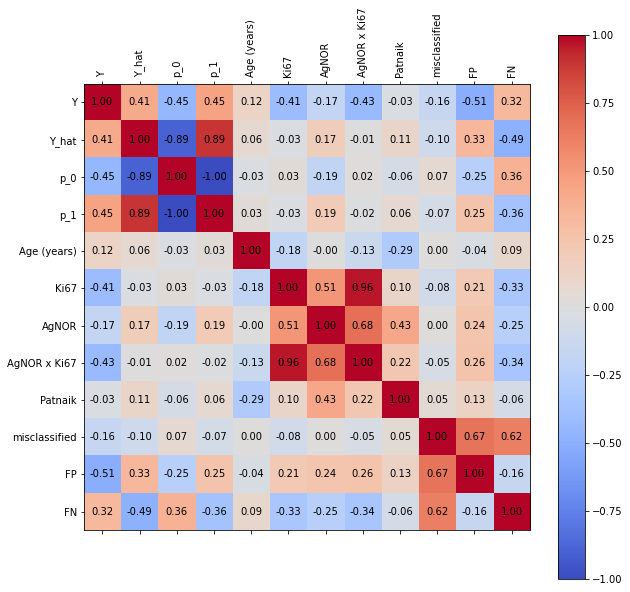

In [26]:
# show correlations between variables

corr = data_joined.corr()

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(corr.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(corr.columns)
ax.set_yticklabels(corr.columns)
for (x, y), value in np.ndenumerate(corr):
    plt.text(x, y, f"{value:.2f}", va="center", ha="center")
plt.show()

In [27]:
data_joined.describe()

,Y,Y_hat,p_0,p_1,Age (years),Ki67,AgNOR,AgNOR x Ki67,Patnaik
count,320.000000,320.000000,320.000000,320.000000,180.000000,320.000000,320.000000,320.000000,300.000000
mean,0.593750,0.612500,0.411719,0.588281,8.388889,27.925000,2.342812,70.859063,2.166667
std,0.491901,0.487942,0.318249,0.318249,2.613649,19.082185,0.576397,53.764826,0.454140
min,0.000000,0.000000,0.011527,0.000017,4.000000,3.000000,1.400000,4.500000,1.000000
25%,0.000000,0.000000,0.119931,0.311872,7.000000,11.300000,1.900000,19.122500,2.000000
50%,1.000000,1.000000,0.339817,0.660183,8.500000,27.600000,2.365000,75.200000,2.000000
75%,1.000000,1.000000,0.688128,0.880069,11.000000,40.450000,2.700000,93.600000,2.000000
max,1.000000,1.000000,0.999983,0.988473,12.000000,66.000000,3.600000,178.200000,3.000000


<AxesSubplot: xlabel='Kiupel', ylabel='proportion'>

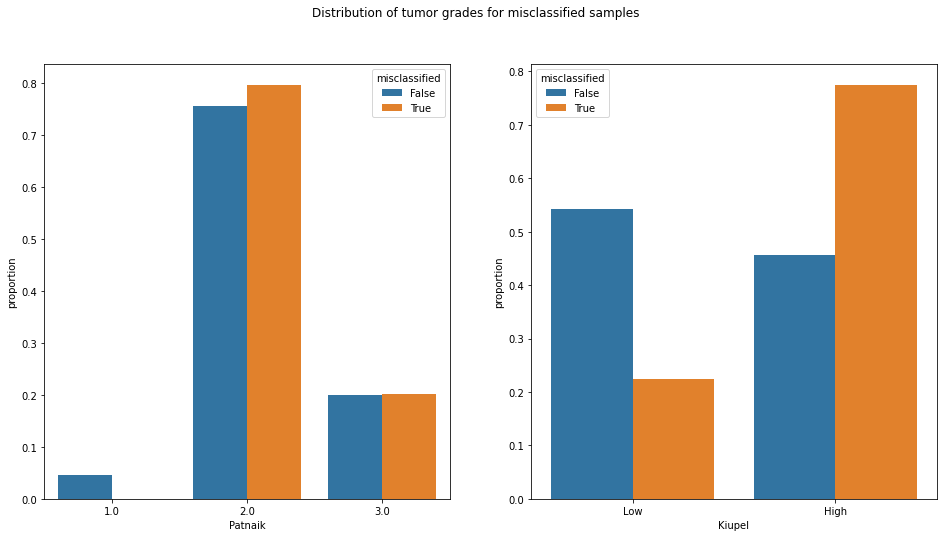

In [28]:
# distribution of tumor grades for accurately classified and misclassified samples
y, hue = "proportion", "misclassified"

fig, ax = plt.subplots(1, 2, figsize=(16,8))
fig.suptitle('Distribution of tumor grades for misclassified samples')

(data_joined['Patnaik']
 .groupby(data_joined[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x='Patnaik', y=y, hue=hue, ax=ax[0]))
(data_joined['Kiupel']
 .groupby(data_joined[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x='Kiupel', y=y, hue=hue, ax=ax[1]))

<AxesSubplot: xlabel='Kiupel', ylabel='proportion'>

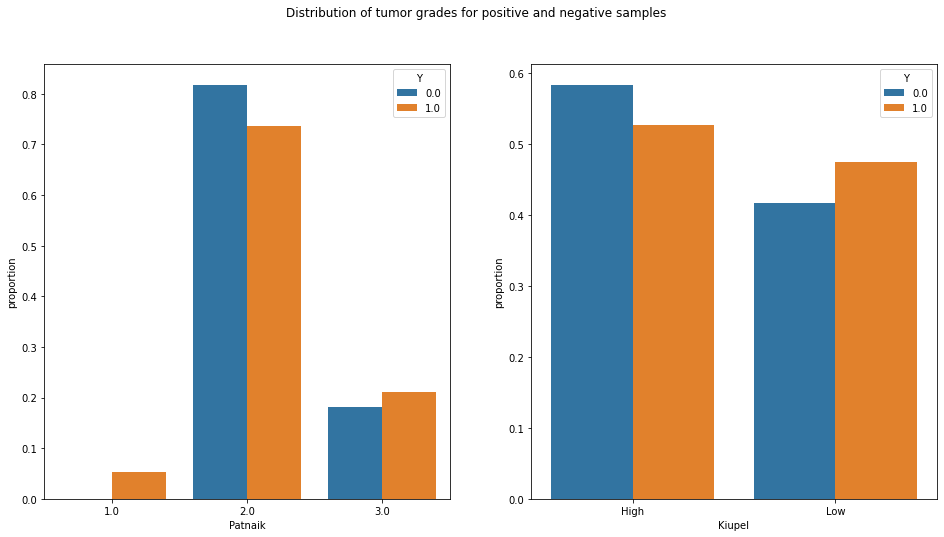

In [29]:
# distribution of tumor grades for positive and negative samples (should be same distribution)
y, hue = "proportion", "Y"

fig, ax = plt.subplots(1, 2, figsize=(16,8))
fig.suptitle('Distribution of tumor grades for positive and negative samples')

(data_joined['Patnaik']
 .groupby(data_joined[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x='Patnaik', y=y, hue=hue, ax=ax[0]))
(data_joined['Kiupel']
 .groupby(data_joined[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x='Kiupel', y=y, hue=hue, ax=ax[1]))

<AxesSubplot: xlabel='Kiupel', ylabel='proportion'>

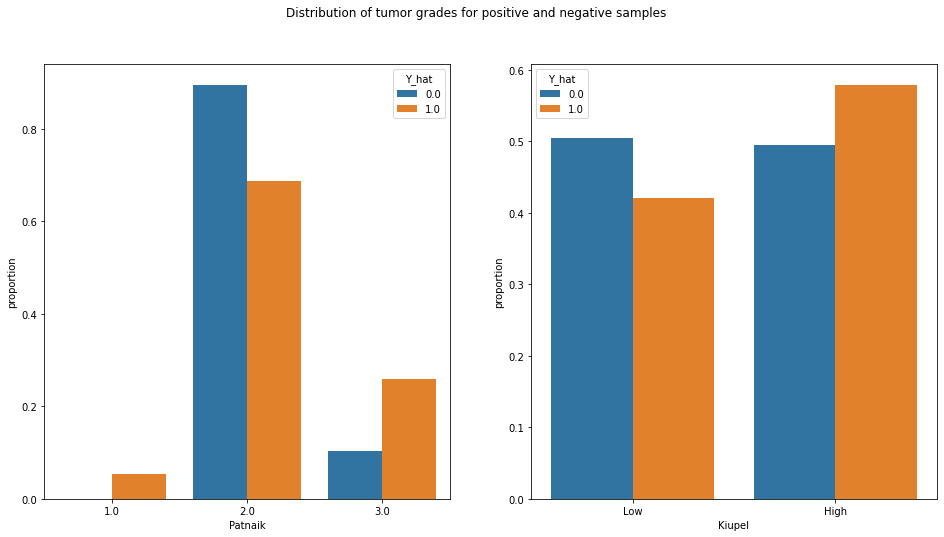

In [30]:
# distribution of tumor grades for positive and negative samples (should be same distribution)
y, hue = "proportion", "Y_hat"

fig, ax = plt.subplots(1, 2, figsize=(16,8))
fig.suptitle('Distribution of tumor grades for positive and negative samples')

(data_joined['Patnaik']
 .groupby(data_joined[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x='Patnaik', y=y, hue=hue, ax=ax[0]))
(data_joined['Kiupel']
 .groupby(data_joined[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x='Kiupel', y=y, hue=hue, ax=ax[1]))

In [31]:
# distribution of tumor grades for FN and TP

def func(x):
    if (x['Y']==1 ) & (x['Y_hat']==0):
        return 'False Neg'
    elif (x['Y']==0 ) & (x['Y_hat']==1):
        return 'False Pos'
    else: 
        return 'True'

data_joined['type'] = data_joined.apply(func, axis=1)


<AxesSubplot: xlabel='Kiupel', ylabel='proportion'>

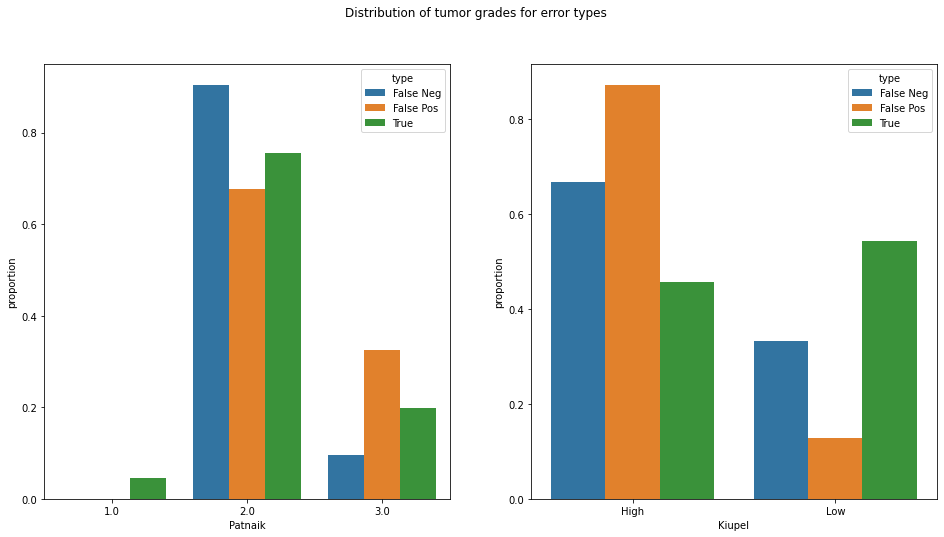

In [32]:
# show distribution of Patnaik Tumor grade for both FN and TP
y, hue = "proportion", "type"

fig, ax = plt.subplots(1, 2, figsize=(16,8))
fig.suptitle('Distribution of tumor grades for error types')

(data_joined['Patnaik']
 .groupby(data_joined[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x='Patnaik', y=y, hue=hue, ax=ax[0]))
(data_joined['Kiupel']
 .groupby(data_joined[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x='Kiupel', y=y, hue=hue, ax=ax[1]))

<AxesSubplot: xlabel='Patnaik', ylabel='AgNOR x Ki67'>

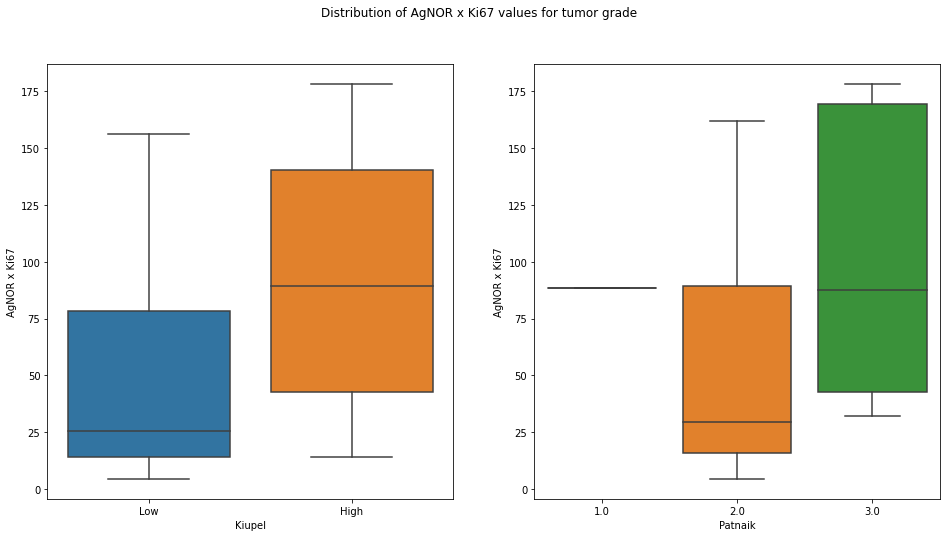

In [33]:
# show agNor and KI67 values for tumor grade

fig, ax = plt.subplots(1, 2, figsize=(16,8))
fig.suptitle('Distribution of AgNOR x Ki67 values for tumor grade')

sns.boxplot(data=data_joined, x='Kiupel', y='AgNOR x Ki67', ax=ax[0])
sns.boxplot(data=data_joined, x='Patnaik', y='AgNOR x Ki67', ax=ax[1])

<AxesSubplot: xlabel='Y_hat', ylabel='AgNOR x Ki67'>

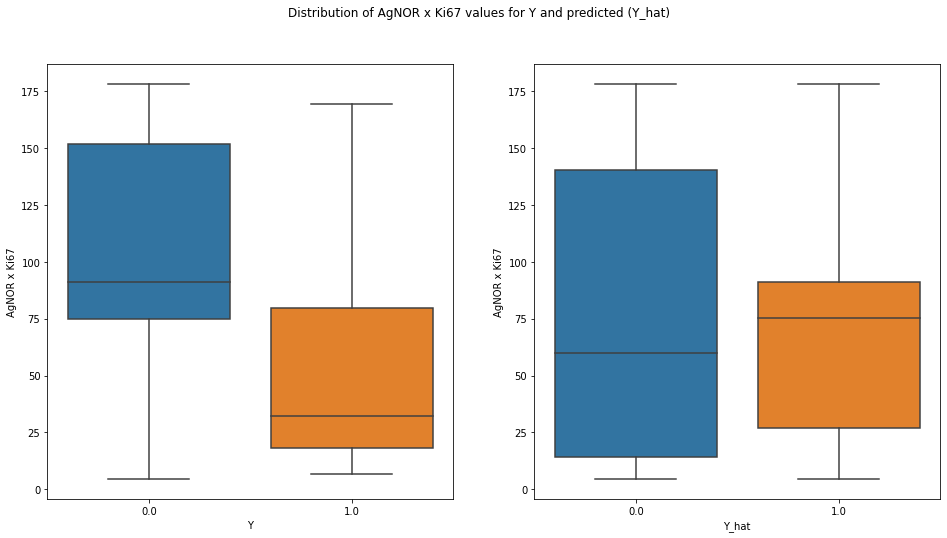

In [34]:
# AgNOR and Ki67 values distribution for Y and Y_hate (prediction)

fig, ax = plt.subplots(1, 2, figsize=(16,8))
fig.suptitle('Distribution of AgNOR x Ki67 values for Y and predicted (Y_hat)')

sns.boxplot(data=data_joined, x='Y', y='AgNOR x Ki67', ax=ax[0])
sns.boxplot(data=data_joined, x='Y_hat', y='AgNOR x Ki67', ax=ax[1])

In [35]:
# Correlations between model prediction and number of patches in WSI

WSI_DIR = '../../../features/pt_files/'

def get_patch_num(wsi):
    tensor = torch.load(WSI_DIR + wsi['slide_id'] + '.pt')
    num = tensor.shape[0]
    return num

data_joined['num_patches'] = data_joined.apply(get_patch_num, axis=1)

<AxesSubplot: xlabel='misclassified', ylabel='num_patches'>

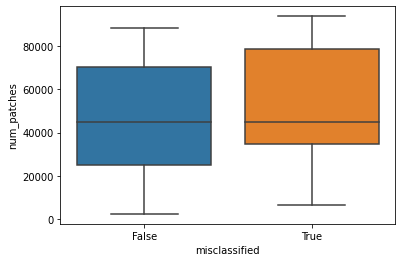

In [36]:
sns.boxplot(data=data_joined, x='misclassified', y='num_patches')